In [78]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from matplotlib.colors import LinearSegmentedColormap

from IPython.display import display, HTML
from jinja2 import Template

In [79]:
# Define the ticker symbol
tickerSymbol = 'f'

# Define the benchmark yield
bm_tickerSymbol = '^IRX'

# How many times the div is paid per year
timePerYear = 4
dividend_ffill_limit = 66 ## trading days 20-ish if dividend is monthly

# Define the number of years prior to the current date
years_prior = 2

In [80]:
def get_summary_report(ticker_symbol):
    try:
        stock = yf.Ticker(ticker_symbol)
        info = stock.info

        summary_report = {
            "Label": info.get("symbol", "N/A"),
            "Exchange": info.get("exchange", "N/A"),
            "Sector": info.get("sector", "N/A"),
            "Industry": info.get("industry", "N/A"),
            "1 Year Target": f"${info.get('targetMeanPrice', 0):.2f}",
            "Today's High/Low": f"${info.get('dayHigh', 0):.2f}/${info.get('dayLow', 0):.2f}",
            "Share Volume": f"{info.get('volume', 0):,.0f}",
            "Average Volume": f"{info.get('averageVolume', 0):,.0f}",
            "Previous Close": f"${info.get('regularMarketPreviousClose', 0):.2f}",
            "52 Week High/Low": f"${info.get('fiftyTwoWeekHigh', 0):.2f}/${info.get('fiftyTwoWeekLow', 0):.2f}",
            "Market Cap": f"${info.get('marketCap', 0):,.0f}",
            "P/E Ratio": f"{info.get('trailingPE', 0):.2f}",
            "Forward P/E 1 Yr.": f"{info.get('forwardPE', 0):.2f}",
            "Earnings Per Share(EPS)": f"${info.get('trailingEps', 0):.2f}",
            "Annualized Dividend": f"${info.get('dividendRate', 0):.2f}",
            "Ex Dividend Date": datetime.fromtimestamp(info.get('exDividendDate', 0)).strftime('%b %d, %Y'),
            "Dividend Pay Date": datetime.fromtimestamp(info.get('lastDividendDate', 0)).strftime('%b %d, %Y'),
            "Current Yield": f"{info['dividendYield']*100:.2f}%" if 'dividendYield' in info and info['dividendYield'] is not None else "N/A",
        }

        return summary_report

    except Exception as e:
        return {"Error": f"Error fetching data for {ticker_symbol}: {e}"}

def generate_html_report(summary_data):
    html_template = '''
    <!DOCTYPE html>
    <html>
    <head>
        <title>Summary Report for {{ summary_data["Label"] }}</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                background-color: #333;
                color: #fff;
            }
            table {
                border-collapse: collapse;
                width: 50%;
                margin: 20px auto;
            }
            th, td {
                padding: 10px;
                border-bottom: 1px solid #ddd;
            }
            th {
                background-color: #f2f2f2;
                color: #000;
                text-align: right;
            }
            td {
                text-align: left;
            }
            h1 {
                text-align: center;
            }
        </style>
    </head>
    <body>
        <h1>Summary Report for {{ summary_data["Label"] }}</h1>
        <table>
            {% for key, value in summary_data.items() %}
            <tr>
                <th>{{ key }}</th>
                <td>{{ value }}</td>
            </tr>
            {% endfor %}
        </table>
    </body>
    </html>
    '''

    template = Template(html_template)
    return template.render(summary_data=summary_data)

In [81]:
# Calculate the start date
current_date = datetime.today()
start_date = current_date - timedelta(days=365 * years_prior)
start_date_str = start_date.strftime('%Y-%m-%d')

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start=start_date_str, end=current_date.strftime('%Y-%m-%d'))
# Fill dividend values that are 0 with the previous non-zero value within the past 3 months
tickerDf['Dividends'] = tickerDf['Dividends'].fillna(method='ffill', limit=dividend_ffill_limit)
# Add a column called dividend_yield that calculates the dividend yield by taking the last dividend payment that is greater than 0 and divides it by the daily closing price
tickerDf['Dividend Yield'] = (tickerDf['Dividends'][tickerDf['Dividends'] > 0].iloc[-1]) / tickerDf['Close'] * 100 * timePerYear

In [82]:
summary_data = get_summary_report(tickerSymbol)
if 'Error' in summary_data:
    print(summary_data['Error'])
else:
    # Generate the complete HTML report
    html_report = generate_html_report(summary_data)

    # Display the HTML report directly in Jupyter Notebook or IPython
    display(HTML(html_report))

Label,F
Exchange,NYQ
Sector,Consumer Cyclical
Industry,Auto Manufacturers
1 Year Target,$12.87
Today's High/Low,$13.75/$13.52
Share Volume,"41,235,487"
Average Volume,"59,643,522"
Previous Close,$13.58
52 Week High/Low,$16.68/$10.90
Market Cap,"$54,690,525,184"


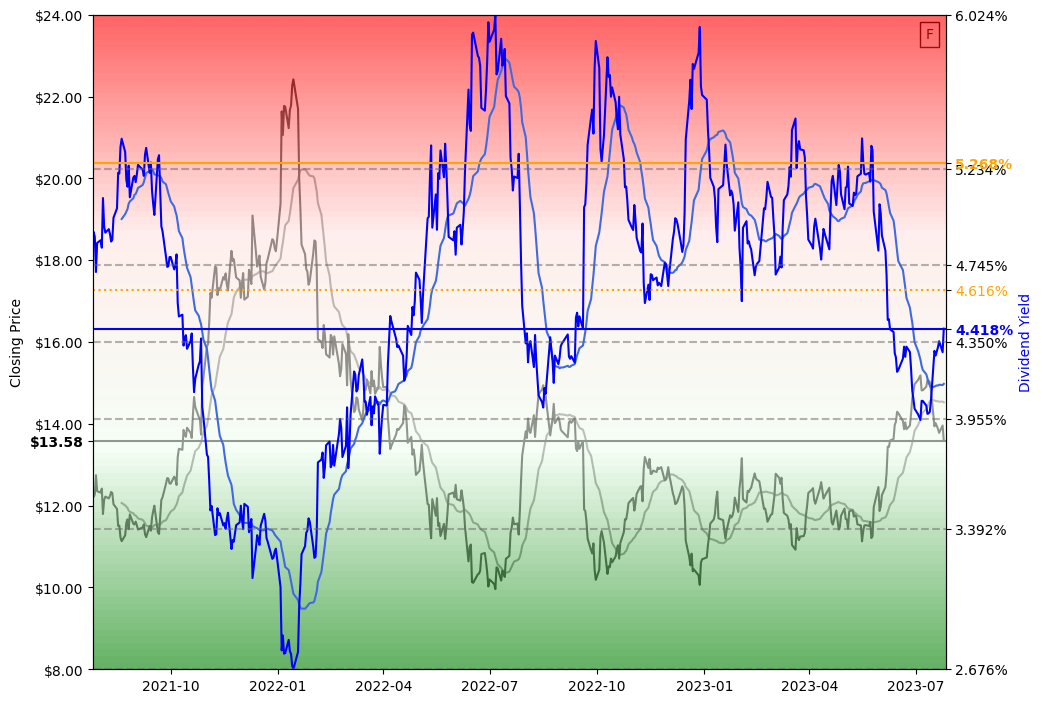

In [84]:
# Get the benchmark rate
bm_tickerData = yf.Ticker(bm_tickerSymbol)
bm_tickerDf = bm_tickerData.history(period='1d')

bm_yield = bm_tickerDf['Close'].iloc[-1]

# Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(11, 8.5))
ax2 = ax1.twinx()

# Plot the data
ax1.plot(tickerDf['Close'].rolling(window=20).mean(), color='dimgray')
ax1.plot(tickerDf['Close'], color='black')
ax2.plot(tickerDf['Dividend Yield'].rolling(window=20).mean(), color='royalblue')
ax2.plot(tickerDf['Dividend Yield'], color='blue')

# Set the limits of the x-axis
ax1.set_xlim(start_date, current_date)

# Fibonacci retracement levels
high = tickerDf['Dividend Yield'].max()
low = tickerDf['Dividend Yield'].min()
diff = high - low

fib_levels = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]
fibonacci_values = [high - level * diff for level in fib_levels]

for level, value in zip(fib_levels, fibonacci_values):
    ax2.axhline(value, linestyle='--', alpha=0.5, color='dimgray')
    #ax2.text(start_date, value, f'{level:.2f} ({value:.2f}%)', color='dimgray', va='center')

# Plot the Average yield
avg_yield = tickerDf['Dividend Yield'].mean()
ax2.axhline(avg_yield, linestyle=':', color='orange')

# Plot the benchmark yield
ax2.axhline(bm_yield, linestyle='-', color='orange')


from matplotlib.font_manager import FontProperties
bold_font = FontProperties(weight='bold')

# Set ticks and add last closing
last_close = tickerDf['Close'][-1]
last_yield = tickerDf['Dividend Yield'][-1]
y1ticks = [*ax1.get_yticks(), last_close]
y1ticklabels = [f'${value:.2f}' for value in y1ticks]
ax1.set_yticks(y1ticks, labels=y1ticklabels)

y1tick_labels = ax1.get_yticklabels()
y1tick_labels[-1].set_font_properties(bold_font)

ax1.axhline(last_close, linestyle='-', color='black')
ax2.axhline(last_yield, linestyle='-', color='blue')

# Set ticks for the average yield and fib levels
y2ticks = fibonacci_values + [bm_yield, avg_yield, tickerDf['Dividend Yield'][-1]]
y2ticklabels = [f'{value:.3f}%' for value in y2ticks]
ax2.set_yticks(y2ticks, labels=y2ticklabels)
#ax2.text(start_date, avg_yield, f'{avg_yield:.2f}%', color='orange', va='center')

# Set the labels and colors for the y-axes
ax1.set_ylabel('Closing Price', color='black')
ax2.set_ylabel('Dividend Yield', color='blue')

# Change the color of the last y-tick label
y2tick_labels = ax2.get_yticklabels()
y2tick_labels[-1].set_color('blue') # Yield based on last closing price
y2tick_labels[-1].set_font_properties(bold_font)
y2tick_labels[-2].set_color('orange') # Average yield
y2tick_labels[-3].set_color('orange') # Benchmark yield
y2tick_labels[-3].set_font_properties(bold_font)

# Create a gradient colormap for the background
colors = ['green','honeydew', 'mistyrose', 'red']
cmap = LinearSegmentedColormap.from_list('gradient', colors)
# Create an array for the gradient background
gradient_data = np.linspace(0, 1, 100).reshape(1, -1)
# Add the gradient background
ax2.imshow(gradient_data.T, aspect='auto', cmap=cmap, extent=[start_date, current_date, high, low], alpha=0.6)

ax2.invert_yaxis()

from matplotlib.offsetbox import AnchoredText
at = AnchoredText(tickerSymbol.capitalize(), loc='upper right', frameon=True)
ax1.add_artist(at)

In [77]:
print(bm_yield)
print(bm_tickerDf)

13.579999923706055
                           Open   High  Low  Close  Volume  Dividends  \
Date                                                                    
2023-07-26 00:00:00-04:00  5.27  5.278  5.1  5.268       0        0.0   

                           Stock Splits  
Date                                     
2023-07-26 00:00:00-04:00           0.0  


In [71]:


dividendsDf = tickerDf[tickerDf['Dividends'] != 0]
print(dividendsDf)


                                Open       High        Low      Close  \
Date                                                                    
2021-11-18 00:00:00-05:00  17.943807  18.032815  17.231752  17.409765   
2022-01-28 00:00:00-05:00  17.284561  17.490329  16.926703  17.481384   
2022-04-25 00:00:00-04:00  13.427923  13.689096  13.166749  13.680090   
2022-08-10 00:00:00-04:00  14.071211  14.171265  13.852911  14.098498   
2022-11-14 00:00:00-05:00  13.078626  13.188917  12.922381  12.922381   
2023-02-10 00:00:00-05:00  12.545055  12.603676  12.222635  12.437581   
2023-04-25 00:00:00-04:00  11.841106  11.850998  11.574013  11.643260   
2023-07-24 00:00:00-04:00  13.890000  14.020000  13.850000  13.960000   

                              Volume  Dividends  Stock Splits  Dividend Yield  
Date                                                                           
2021-11-18 00:00:00-05:00  111368800       0.10           0.0        3.446342  
2022-01-28 00:00:00-05:00   8